# 04_Fast_C

In [1]:
import numpy as np
import random
import torch
torch.cuda.set_device(0)

In [2]:
random_seed = 617
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)
print("Random Seed:",random_seed)

Random Seed: 617


In [3]:
# Import utils from a specific defense
from defenses.base.loader import get_loader
from defenses.base.model import get_model
from defenses.fast.train import Trainer, get_acc

Loader : Base
Model : Base
Train : Fast


In [4]:
# Set Name
NAME = "04_Fast_C"

## 1. Train

In [5]:
# Get Train, Test datasets
train_loader_ns, _ = get_loader(shuffle_train=False)
train_loader, test_loader = get_loader(shuffle_train=True)

# Get Model
model = get_model().cuda()

Files already downloaded and verified
Files already downloaded and verified
Data Loaded!
Train Data Length : 50000
Test Data Length : 10000
Files already downloaded and verified
Files already downloaded and verified
Data Loaded!
Train Data Length : 50000
Test Data Length : 10000
WRN-28 is loaded.


In [6]:
train_sets = iter(train_loader_ns).next()
test_sets = iter(test_loader).next()

In [7]:
# Train Model
trainer = Trainer(model, train_sets, test_sets,
                  eps=8/255, alpha=10/255)
trainer.train(train_loader, epochs=30,
              save_path="./_models/"+NAME, scheduler="Cyclic", 
              record_type="Epoch", save_type="Epoch")

Train Information:
-Epochs: 30
-Optimizer: SGD (
Parameter Group 0
    dampening: 0
    initial_lr: 0
    lr: 0.0
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0005
)
-Scheduler: <torch.optim.lr_scheduler.CyclicLR object at 0x7f34232e3898>
-Save Path: ./_models/04_Fast_C
-Save Type: Per Epoch
-Record Type: Per Epoch
-Device: cuda
--------------------------------------------------------------------------------------------------------------------------
Epoch   Loss     Acc       Clean(Tr)   FGSM(Tr)   PGD(Tr)   GN(Tr)    Clean(Te)   FGSM(Te)   PGD(Te)   GN(Te)    lr       
1       2.0973   20.7732   25.0000     15.6250    14.0625   27.3438   39.0625     25.7812    25.0000   37.5000   0.0133   
--------------------------------------------------------------------------------------------------------------------------
2       1.9506   26.3081   33.5938     17.9688    17.1875   33.5938   37.5000     23.4375    21.0938   37.5000   0.0267   
-----------------------------------------

In [8]:
trainer.save_all("./_models/"+NAME)

...Saved as csv to ./_models/04_Fast_C.csv !


In [9]:
print("Final Test Acc : %2.2f"%get_acc(model, test_loader))

Final Test Acc : 78.94


## 2. Record Visualization

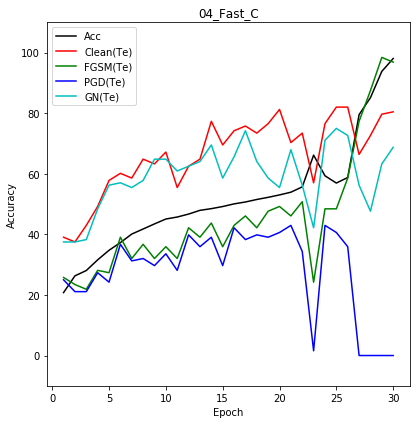

In [10]:
# Plot Train and Test Accuracy
trainer.rm.plot(title=NAME, xlabel="Epoch", ylabel="Accuracy", ylabel_second="Loss",
                x_key='Epoch', y_keys=['Acc', 'Clean(Te)', 'FGSM(Te)', 'PGD(Te)', 'GN(Te)'],
                ylim=(-10, 110), colors=['k', 'r', 'g', 'b', 'c'])

## 3. White Box Attack

In [11]:
import torchattacks
from torchattacks import FGSM, PGD, MultiAttack

In [12]:
model.load_state_dict(torch.load("./_models/"+NAME+".pth"))
model = model.cuda().eval()

### 3.1 FGSM

In [13]:
fgsm = FGSM(model, eps=8/255)
fgsm.set_mode('int')
fgsm.save(data_loader=test_loader,
          file_name="./_datasets/"+NAME+"_FGSM.pt", accuracy=True)

- Save Progress : 100.00 % / Accuracy : 97.18 %
- Save Complete!


### 3.2 PGD

In [14]:
# WB2 : PGD
pgd = PGD(model, alpha=2/255, eps=8/255, iters=50)
pgd.set_mode('int')
pgd.save(data_loader=test_loader,
         file_name="./_datasets/"+NAME+"_PGD.pt", accuracy=True)

- Save Progress : 100.00 % / Accuracy : 0.00 %
- Save Complete!


### 3.3 PGD with 10 Random Restarts

In [15]:
# WB3 : PGD
pgd = PGD(model, alpha=2/255, eps=8/255, iters=50, random_start=True)
multi = MultiAttack(model, [pgd]*10)
multi.set_mode('int')
multi.save(data_loader=test_loader,
           file_name="./_datasets/"+NAME+"_RPGD.pt", accuracy=True)

/usr/local/lib/python3.6/dist-packages/torchattacks/attacks/multiattack.py:58: Warning:


 * Ealry Stopped cause all images are successfully perturbed.



- Save Progress : 100.00 % / Accuracy : 0.00 %
- Save Complete!


## 4. Black Box Attack

In [16]:
from torch.utils.data import TensorDataset, DataLoader

In [17]:
# BB1 : WRN_28_20
adv_images, adv_labels = torch.load("./_datasets/00_WRN_28_20_PGD.pt")
adv_data = TensorDataset(adv_images.float()/255, adv_labels)
adv_loader = DataLoader(adv_data, batch_size=128, shuffle=False)
get_acc(model, adv_loader)

78.57

In [18]:
# BB2 : WRN_40_10
adv_images, adv_labels = torch.load("./_datasets/00_WRN_40_10_PGD.pt")
adv_data = torch.utils.data.TensorDataset(adv_images.float()/255, adv_labels)
adv_loader = DataLoader(adv_data, batch_size=128, shuffle=False)
get_acc(model, adv_loader)

78.78